In [93]:
# Imports
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import cv2 as cv
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from copy import deepcopy

In [2]:
pip install validclust

Load cifar-10 dataset from Keras

In [94]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data() 

Plot Training data

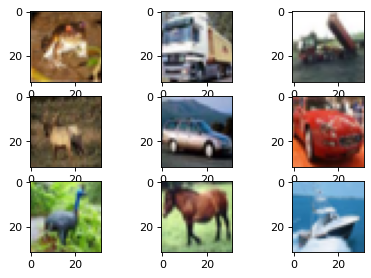

In [95]:
from matplotlib.pyplot import figure

figure(figsize=(6, 4), dpi=80)
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i])
plt.show()

In [96]:
x_test.shape

(10000, 32, 32, 3)

In [97]:
# Retain shapes of x_train and x_test
X_train = x_train
X_test = x_test

Initial size of the array is (10,000 * (32,32,3))

After grey scaling the images, the size would be 10000*(32,32)

In [98]:
x_train = np.array([cv.cvtColor(img, cv.COLOR_BGR2GRAY) for img in x_test])
p,q,r = x_train.shape
x_train = x_train.reshape((p,q*r))
print('Train dataset shape: {}'.format(x_train.shape))

Train dataset shape: (10000, 1024)


# **Part 1: K-Means Clustering**

Initialize 10 centroids at random points

In [112]:
def initialize_random_centroids(data, number_of_features):
  number_of_clusters = 10
  mean_value = np.mean(data, axis = 0)
  std_value = np.std(data, axis = 0)
  return np.random.randn(number_of_clusters,number_of_features)*std_value + mean_value

**Defining K-means function:**

-> After selecting k samples at random from the dataset to be the initial clusters (We have k as 10)

-> Calculate the Euclidean distance between every object and the centroid.

-> Now assign the objects to the nearest cluster.

-> For each of the k clusters, update the cluster centroids (old_centroids to new_centroids) by calculating the mean of all the data points in that cluster.

-> Iteratively repeat above 2 steps until we reach terminate condition i.e the error is less than tolerance (0.0001) or the Iterations reach the assigned max_iterations

In [113]:
def kmeans(number_of_clusters, data, max_iterations, tolerance=0.0001):
  cluster_labels_ = np.array([])
  number_of_instances = data.shape[0]
  # Get the number of features by multiplying the n-dimensions
  number_of_features = np.prod([data.shape[x] for x in range(len(data.shape)) if data.shape[x] != number_of_instances])
  features_shape = tuple(data.shape[x] for x in range(len(data.shape)) if data.shape[x] != number_of_instances)
  # Reshape the data to 2-D if data is more than 2-dimensional
  if(len(data.shape) > 2):
      data = data.reshape(number_of_instances, number_of_features)
  
  restart_score_best = np.inf
  centroids = initialize_random_centroids(data, number_of_features)
  old_centroids = np.zeros(centroids.shape) 
  # new_centroids will have the updated centroids after each iteration
  new_centroids = deepcopy(centroids) 
  # Error of each iteration is stored in error variable
  error = np.linalg.norm(new_centroids - old_centroids)
  # Store distances between all points and centroids
  distances = np.zeros((number_of_instances,number_of_clusters))
  distoration_measure = 0
  # Cluster labels are stored for each instance
  cluster_labels = np.zeros(number_of_instances)
  iter_num = 0

  while error > tolerance and iter_num < max_iterations:
      # distance is calculated to every center below
      for i in range(number_of_clusters):
          distances[:,i] = np.linalg.norm(data - new_centroids[i], axis=1)

      # Assigning all training data to nearest center
      cluster_labels = np.argmin(distances, axis = 1)
      old_centroids = deepcopy(new_centroids)
      # Calculating the mean for every cluster and then updating the center
      for i in range(number_of_clusters):
          new_centroids[i] = np.mean(data[cluster_labels == i], axis=0)
      error = np.linalg.norm(new_centroids - old_centroids)
      distoration_measure = np.sum(distances)
      print("<--- Iteration: ", iter_num+1," --->")
      print("Error : ", error)
      print("Distortion Measure score : ", distoration_measure)
      iter_num +=1

  cluster_labels_ = cluster_labels
  new_centroids_shape = [number_of_clusters]
  new_centroids_shape.extend(features_shape)
  centroids = new_centroids.reshape(new_centroids_shape)
  distoration_measure = distoration_measure
  iteration_number = iter_num
  return centroids,iteration_number,distoration_measure

In [115]:
num_clusters = 10
max_iterations = 300
centroids,iteration_number,distoration_measure = kmeans(num_clusters, x_train, max_iterations)

<--- Iteration:  1  --->
Error :  6846.2645457969165
Distortion Measure score :  274149632.5430145
<--- Iteration:  2  --->
Error :  1089.0262632056351
Distortion Measure score :  213751353.37624848
<--- Iteration:  3  --->
Error :  400.1280645279001
Distortion Measure score :  219154319.54726315
<--- Iteration:  4  --->
Error :  231.61935178568575
Distortion Measure score :  220760287.74881786
<--- Iteration:  5  --->
Error :  164.18861010185287
Distortion Measure score :  221633938.10626364
<--- Iteration:  6  --->
Error :  118.68699334328537
Distortion Measure score :  222235633.46113873
<--- Iteration:  7  --->
Error :  108.1612104127479
Distortion Measure score :  222608087.60992962
<--- Iteration:  8  --->
Error :  104.7506712366079
Distortion Measure score :  222965910.08692127
<--- Iteration:  9  --->
Error :  84.93552548972806
Distortion Measure score :  223297733.24462327
<--- Iteration:  10  --->
Error :  66.56413056722597
Distortion Measure score :  223594285.6343086
<--- I

In [116]:
print("Model took ",iteration_number," iterations to converge.")
print("Model's distortion measure value: ",distoration_measure)

Model took  29  iterations to converge.
Model's distortion measure value:  224173816.7808051


**Silhouette Score and Dunn's Index**

In [117]:
#Imports
from sklearn.metrics import pairwise_distances
from validclust import dunn
from sklearn.decomposition import PCA

In [118]:
# Calculate distance between every pair of samples using pairwise_distances from sklearn
distance1 = pairwise_distances(x_train)

In [119]:
# Calculate distances of centroids and points from distances array
distances_array = cdist(x_train, centroids, 'euclidean')
points = np.array([np.argmin(i) for i in distances_array])

In [120]:
print('silhouette_score: ',silhouette_score(x_train,points))
print('Dunn index: ',dunn(distance1,points))

silhouette_score:  0.05978191335608655
Dunn index:  0.09121709729952622


**Visualizing the final clusters**

In [110]:
colors=['red','black','green','pink','yellow','hotpink','blue','orange','gray','indigo']
pca = PCA(1024)
df = pca.fit_transform(x_train)
print(df.shape)

(10000, 1024)


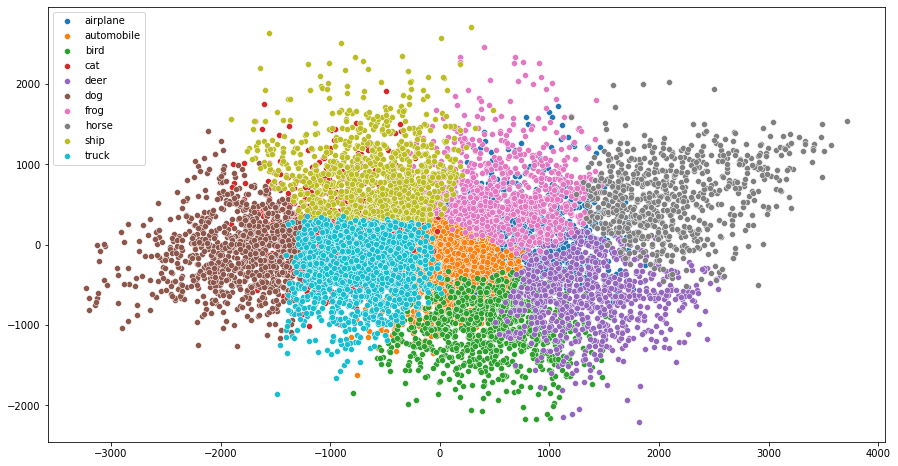

In [111]:
label=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
import seaborn as sns
figure(figsize=(15, 8))

for i in range(10):
  sns.scatterplot(data=df, x=df[points==i][:,0],y=df[points==i][:,1],palette='cool')
plt.legend(label)
plt.show()

# **Part 2: Implement Auto-Encoder**

In [18]:
# Imports
import tensorflow as tf
from keras.layers import Input, MaxPooling2D, Activation, Conv2D, UpSampling2D, BatchNormalization
from keras.models import Sequential
from keras.models import Model

In [19]:
# normalize data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [20]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [21]:
# divide x_test into validation and test
X_val = X_test[:7000]
X_test = X_test[7000:]

**Implementing Convolutional Auto-Encoder**

In [22]:
input_image = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_image)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encodeModel = keras.Model(input_image, encoded, name="Encoder")

# Decoder
x = Conv2D(32, (3, 3), padding='same', activation='relu')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
decoded = BatchNormalization()(x)


model = keras.Model(input_image, decoded)
model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128   

**Training the Auto-Encoder**

In [24]:
h = model.fit(X_train, X_train,
            batch_size=64,
            epochs=75,
            verbose=1,
            validation_data=(X_val, X_val),
            shuffle=True)

Epoch 1/75
782/782 [==============================] - 14s 18ms/step - loss: 0.0144 - accuracy: 0.6542 - val_loss: 0.0680 - val_accuracy: 0.6696
Epoch 2/75
782/782 [==============================] - 13s 17ms/step - loss: 0.0120 - accuracy: 0.6850 - val_loss: 0.0304 - val_accuracy: 0.7167
Epoch 3/75
782/782 [==============================] - 13s 17ms/step - loss: 0.0105 - accuracy: 0.7006 - val_loss: 0.0191 - val_accuracy: 0.6876
Epoch 4/75
782/782 [==============================] - 13s 17ms/step - loss: 0.0094 - accuracy: 0.7136 - val_loss: 0.1448 - val_accuracy: 0.5654
Epoch 5/75
782/782 [==============================] - 13s 17ms/step - loss: 0.0096 - accuracy: 0.7094 - val_loss: 0.0173 - val_accuracy: 0.7130
Epoch 6/75
782/782 [==============================] - 13s 17ms/step - loss: 0.0099 - accuracy: 0.7073 - val_loss: 0.0120 - val_accuracy: 0.6988
Epoch 7/75
782/782 [==============================] - 13s 17ms/step - loss: 0.0086 - accuracy: 0.7229 - val_loss: 0.0083 - val_accuracy:

**Evaluate with test dataset**

In [25]:
score = model.evaluate(X_test, X_test, verbose=1)
print(score)

94/94 [==============================] - 1s 7ms/step - loss: 0.0047 - accuracy: 0.7909
[0.004740986507385969, 0.7909479141235352]


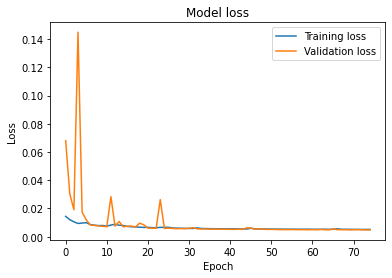

In [26]:
#visualize the training loss and the validation loss to see if the model is overfitting
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

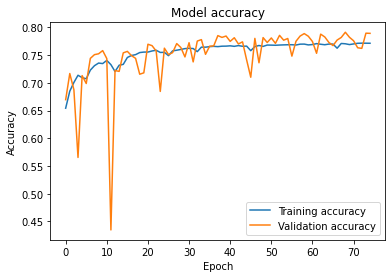

In [27]:
#visualize the training accuracy and the validation accuracy to see if the model is overfitting
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

**Visualize original image and reconstructed image**

In [28]:
# Function to show original image and reconstructed image
def showOriginalDecodedImages(original, decoded, number=10):
    import matplotlib.pyplot as plt
    n = number
    plt.figure(figsize=(16, 4))

    for i in range(n):
        # display original
        a_x = plt.subplot(2, n, i+1)
        plt.imshow(original[i].reshape(32, 32, 3))
        a_x.get_xaxis().set_visible(False)
        a_x.get_yaxis().set_visible(False)

        # display reconstructed image (decoded image)
        a_x = plt.subplot(2, n, i +1 + n)
        plt.imshow(decoded[i].reshape(32, 32, 3))
        a_x.get_xaxis().set_visible(False)
        a_x.get_yaxis().set_visible(False)
    plt.show()

In [29]:
decodedImages = model.predict(X_train) # decoded images

In [30]:
encodedImages = encodeModel.predict(X_train) #encoded images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


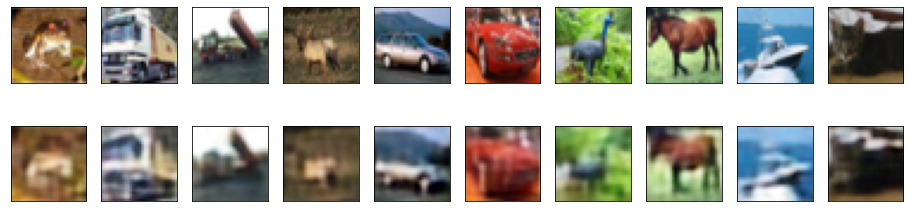

In [31]:
# Comparing original image and reconstructed image using train data
showOriginalDecodedImages(X_train, decodedImages)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


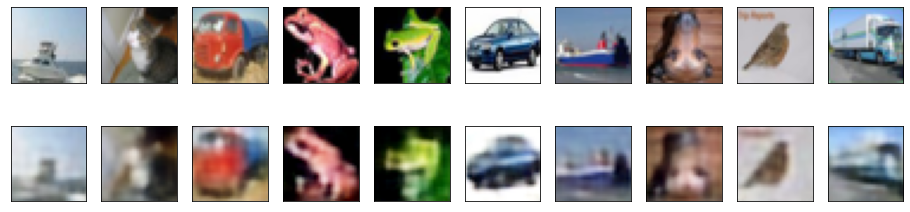

In [32]:
# Comparing original image and reconstructed image using train data (starting from 100th image)
showOriginalDecodedImages(X_train[100:], decodedImages[100:])

**Generating clusters using K-Means function from the sparse representations generated by the Auto-Encoder**

In [33]:
# Imports
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
encodedImages = encodedImages.reshape(-1,1024)


**Silhouette Score and Dunn's Index for Auto-Encoder**


In [34]:
# Using decoded images, perform kmeans from sklearn
kmeans.fit(encodedImages)
points_ = kmeans.predict(encodedImages)

In [35]:
# Calculate distance between every pair of samples using pairwise_distances from sklearn
distance2 = pairwise_distances(encodedImages)

In [36]:
print('silhouette_score: ',silhouette_score(encodedImages,points_))
print('Dunn index: ',dunn(distance2,points_))

silhouette_score:  0.03913329
Dunn index:  0.184344
